<div align="center">
    
## "Analyzing Promotional Strategy Effectiveness: A Mixed Effects Approach to Observational Retail Data"

</div>

<div align="center">

### by Rob Boswell

</div>

<div align="center">    

### Feb 2026

</div>


---

Reference
1.https://www.ibm.com/communities/analytics/watson-analytics-blog/marketing-campaign-eff-usec_-fastf/

---

In [1]:
import os
os.getcwd()

'/mnt/c/Users/rsb84/AppData/Local/Programs/Microsoft VS Code'

In [2]:
os.chdir("/mnt/c/Users/rsb84/Downloads/Mixed_Effects_in_Python")

In [3]:
import pandas as pd
df=pd.read_csv("WA_Marketing-Campaign.csv")

#### Check for normality - an assumption for many empirical tests

In [4]:
df

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


In [12]:
# Convert categorical variables to category dtype
df['Promotion'] = df['Promotion'].astype('category')
df['week'] = df['week'].astype('category')
df['MarketID'] = df['MarketID'].astype('category')
df['LocationID'] = df['LocationID'].astype('category')

# Keep AgeOfStore as numeric (continuous)
df['AgeOfStore'] = df['AgeOfStore'].astype(float)

# Verify
print("Variable types for Low Mode:")
print(df.dtypes)

Variable types for Low Mode:
MarketID            category
MarketSize            object
LocationID          category
AgeOfStore           float64
Promotion           category
week                category
SalesInThousands     float64
dtype: object


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

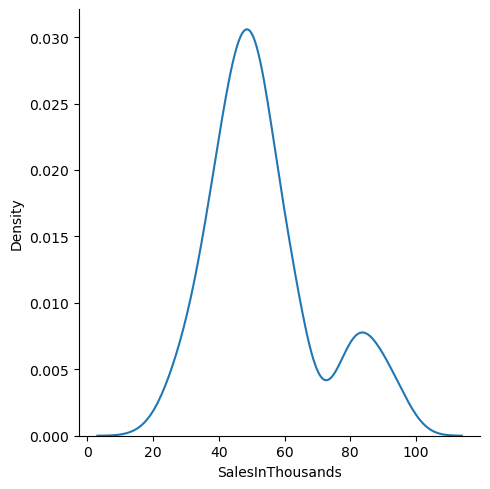

In [14]:
sns.displot(data=df, x="SalesInThousands", kind="kde")
plt.show()

#### We can see the data has a binomial - not a normal - distribution. It is important to not rely on tests that assume normality.

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

#### **Research Question:** Is promotion type associated with weekly sales? If so, how?

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MarketID          548 non-null    category
 1   MarketSize        548 non-null    object  
 2   LocationID        548 non-null    category
 3   AgeOfStore        548 non-null    float64 
 4   Promotion         548 non-null    category
 5   week              548 non-null    category
 6   SalesInThousands  548 non-null    float64 
dtypes: category(4), float64(2), object(1)
memory usage: 21.5+ KB


Diagnose why it is bimodal:

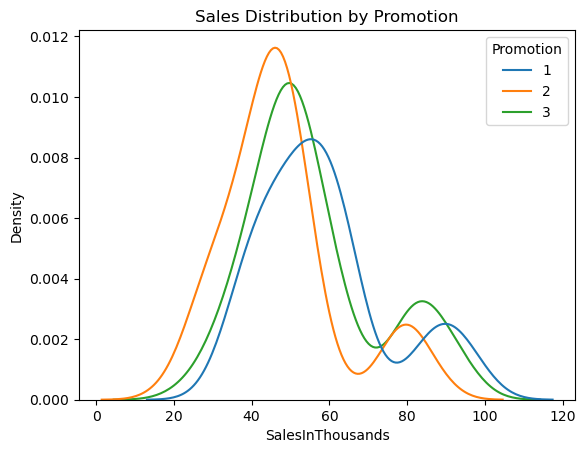

In [17]:
sns.kdeplot(data=df, x='SalesInThousands', hue='Promotion')
plt.title("Sales Distribution by Promotion")
plt.show()

#### We can see here that visualizing sales by promotion type shows 3 roughly similar bimodal distributions. Promotion does not appear to be the cause of the bimodal distribution in SalesInThousands. Therefore, I should analyze other variables.

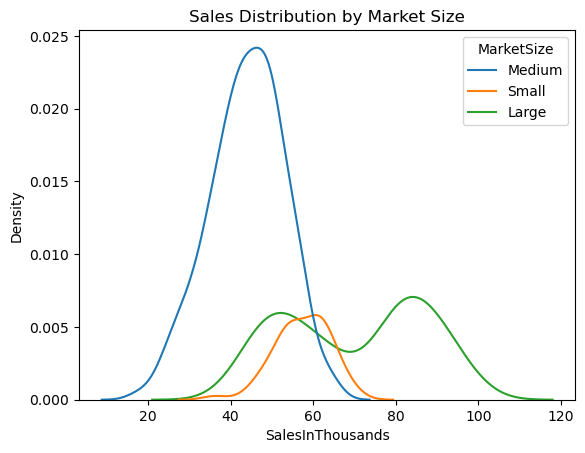

In [18]:
sns.kdeplot(data=df, x='SalesInThousands', hue='MarketSize')
plt.title("Sales Distribution by Market Size")
plt.show()

#### It appears that the medium market size makes up, by far, the largest portion of the sales around `$40,000`. The small market size has its largest portion of sales around `$60,000`. But the large market size has a bimodal distribution of around `$50,000` and around `$85,000` in sales. This leads me to believe the overall bimodality is not coming from a single homogeneous population. Instead, one mode comes from small, medium, and large size markets, while the other mode comes from only large size markets. Thus, we do not have just one study - we have at least two. Market size so far appears to be a major suspect leading to the bimodal distribution in SalesInThousands.

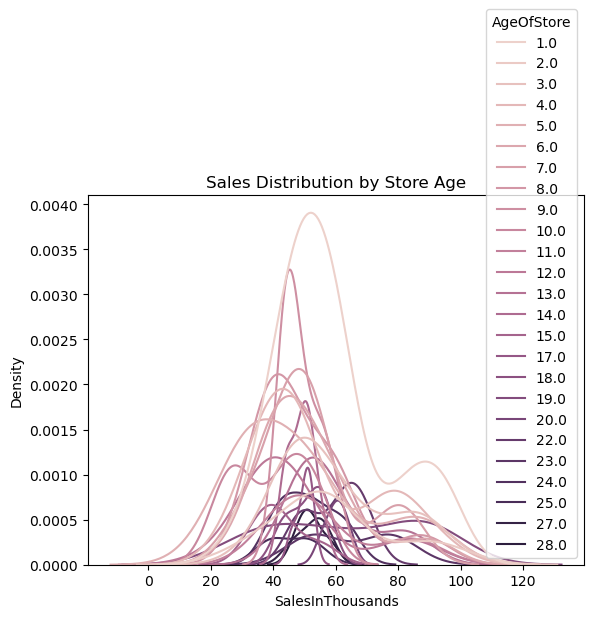

In [19]:
sns.kdeplot(data=df, x='SalesInThousands', hue='AgeOfStore')
plt.title("Sales Distribution by Store Age")
plt.show()

#### **What we can see from the plot:**

#### - The vast majority of store ages peak in the same region (~40–60)

#### - Some older stores have heavier right tails

#### - No clean separation by age

<br>

#### **Interpretation:**

#### - Store age modulates variance

#### - Store age does not create the modes

#### - Store age is a secondary effect, not the driver of the bimodal distribution in SalesInThousands

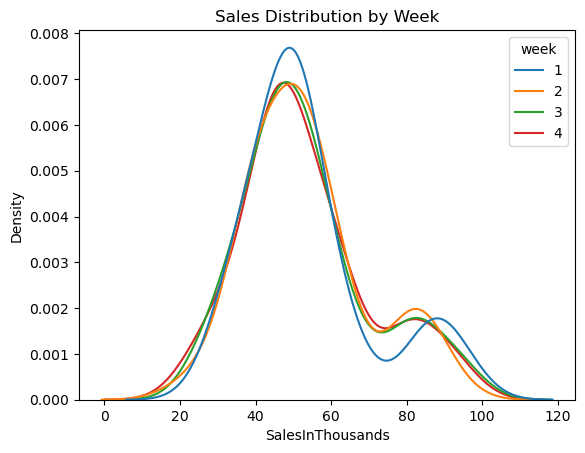

In [20]:
sns.kdeplot(data=df, x='SalesInThousands', hue='week')
plt.title("Sales Distribution by Week")
plt.show()

#### This visualization again shows 3 bimodal distributions largely overlapping one another. Thus, week is not the cause of SalesInThousands' bimodal distribution.

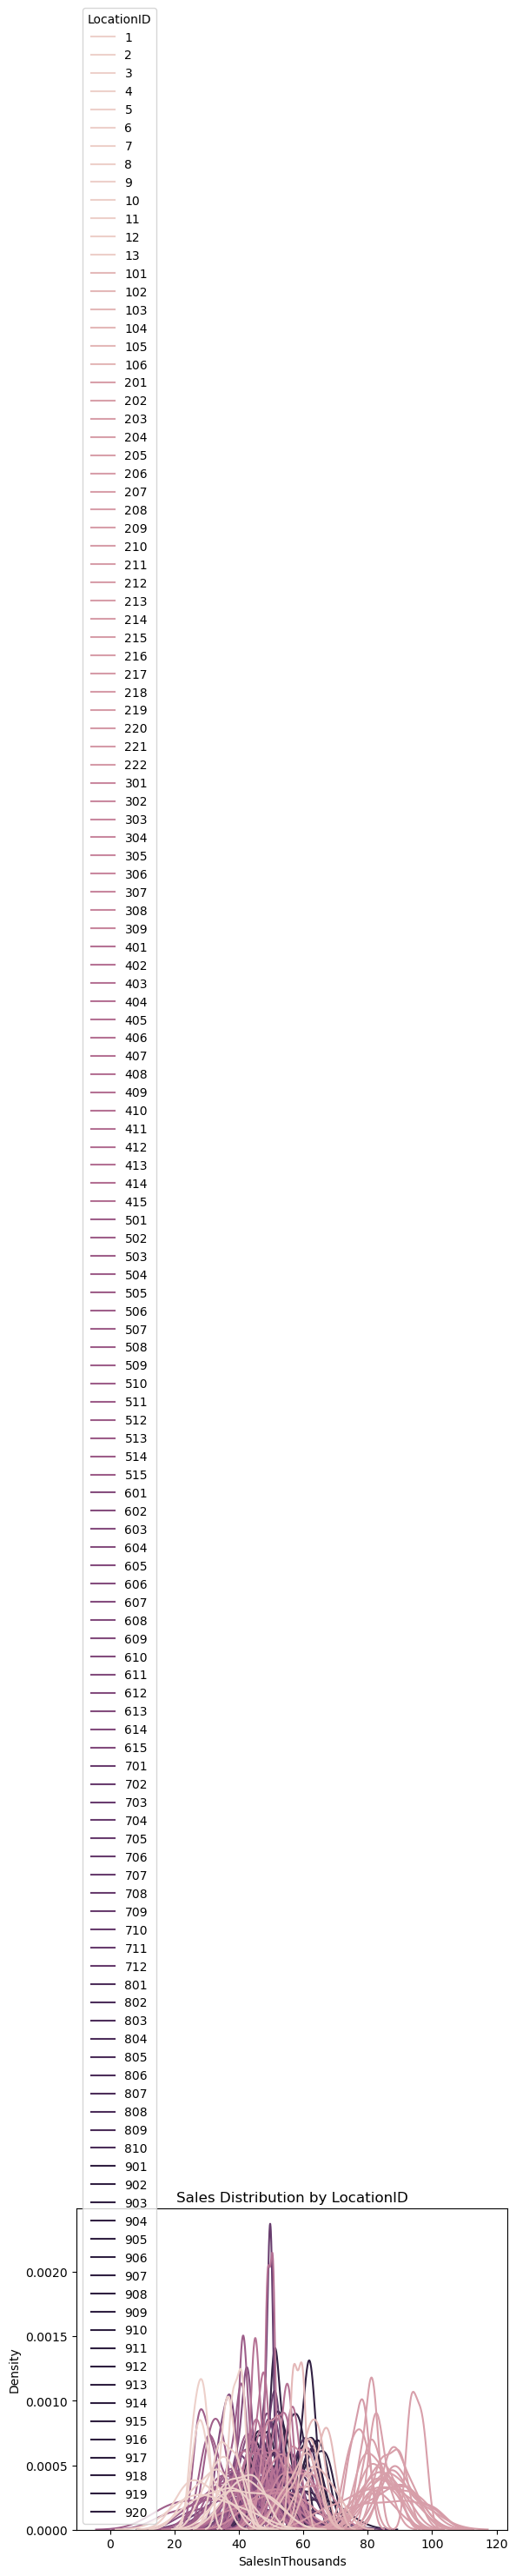

In [24]:
sns.kdeplot(data=df, x='SalesInThousands', hue='LocationID')
plt.title("Sales Distribution by LocationID")
plt.show()

#### This plot is very messy, but we can see a divide between most of the SalesInThousands by LocationID distributions having mean values somewhere between `$25,000` to `$70,000` with the bulk around `$50,000`, and the minority of distributions having mean values falling between `$80,000` and `$95,000`, with the bulk around `$85,000` to `$90,000`. Thus, LocationID appears to also be leading to SalesInThousands' bimodal distribution.

In [36]:
def analyze_group_statistics(df=df, target='SalesInThousands'):
    """
    Check mean and median for each categorical variable to see which
    creates the clearest separation.
    """
    categorical_cols = ['MarketSize', 'LocationID', 'AgeOfStore','Promotion', 'Week']
    
    print("="*70)
    print("METHOD: Group Statistics")
    print("="*70)
    
    for col in categorical_cols:
        if col in df.columns:
            print(f"\n{col}:")
            stats_df = df.groupby(col)[target].agg(['mean', 'median', 'std', 'count'])
            print(stats_df.round(2))
            
            # Calculate the range of means (larger = more likely cause)
            mean_range = stats_df['mean'].max() - stats_df['mean'].min()
            print(f"Range of means: {mean_range:.2f}")

In [37]:
analyze_group_statistics()

METHOD: Group Statistics

MarketSize:
             mean  median    std  count
MarketSize                             
Large       70.12   75.02  17.05    168
Medium      43.99   44.59   9.05    320
Small       57.41   57.56   6.63     60
Range of means: 26.13

LocationID:
             mean  median   std  count
LocationID                            
1           34.42   34.70  4.26      4
2           29.54   27.90  3.42      4
3           40.68   41.24  5.19      4
4           33.71   35.13  7.20      4
5           29.00   27.60  6.40      4
...           ...     ...   ...    ...
916         47.76   47.96  3.54      4
917         52.97   52.66  2.62      4
918         55.98   55.87  7.07      4
919         61.10   61.43  3.20      4
920         47.41   47.58  2.84      4

[137 rows x 4 columns]
Range of means: 67.25

AgeOfStore:
             mean  median    std  count
AgeOfStore                             
1.0         58.42   55.17  17.41     80
2.0         59.18   56.80  19.01     20
3

/tmp/ipykernel_895/2275068829.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_df = df.groupby(col)[target].agg(['mean', 'median', 'std', 'count'])
/tmp/ipykernel_895/2275068829.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_df = df.groupby(col)[target].agg(['mean', 'median', 'std', 'count'])


#### We will now divide the dataset into the two groups, each one varying on the value of LocationID. We will do this since we know that LocationID is helping to cause the bimodal distribution in SalesInThousands because it is clearly the variable with the highest range of means (67.25).

#### Since MarketSize has the next highest range of means (26.13), it may be that I will need to further divide the data into additional datasets if multiple modes can still be detected after initially dividing the data based on the LocationID value. I will thereafter conduct the observational study on each dataset separately.

In [23]:
# =============================================================================
# METHOD: Simple Threshold (Recommended for interpretability)
# =============================================================================
def threshold_grouping(df=df, target='SalesInThousands', group_col='LocationID', threshold=None):
    """
    Group locations based on whether their mean is above or below the valley
    between the two modes.
    
    This is often the BEST approach because:
    - It's simple and interpretable
    - The threshold has real meaning (the valley between modes)
    - Easy to explain to stakeholders
    """
    print("="*70)
    print("METHOD: Threshold-Based Grouping")
    print("="*70)
    
    # Calculate mean for each location
    location_means = df.groupby(group_col)[target].mean()
    
    # If no threshold provided, estimate the valley between modes
    if threshold is None:
        # Use kernel density to find the valley
        kde = stats.gaussian_kde(df[target].dropna())
        x = np.linspace(df[target].min(), df[target].max(), 1000)
        density = kde(x)
        
        # Find local minimum between the two peaks
        from scipy.signal import find_peaks
        
        # Find peaks first
        peaks, _ = find_peaks(density, height=0.001)
        if len(peaks) >= 2:
            # Find minimum between the two highest peaks
            peak_indices = sorted(peaks[:2])
            valley_region = density[peak_indices[0]:peak_indices[1]]
            valley_idx = peak_indices[0] + np.argmin(valley_region)
            threshold = x[valley_idx]
        else:
            # Fallback: use median
            threshold = df[target].median()
    
    print(f"Threshold (valley between modes): {threshold:.2f}")
    
    # Assign groups
    low_mode_locations = location_means[location_means < threshold].index.tolist()
    high_mode_locations = location_means[location_means >= threshold].index.tolist()
    
    print(f"\nLow Mode Locations (mean < {threshold:.2f}): {len(low_mode_locations)}")
    print(f"High Mode Locations (mean >= {threshold:.2f}): {len(high_mode_locations)}")
    
    # Create a mapping
    location_groups = pd.DataFrame({
        'LocationID': location_means.index,
        'MeanSales': location_means.values,
        'Group': ['High Mode' if m >= threshold else 'Low Mode' for m in location_means.values]
    })
    
    # Summary statistics
    print("\nGroup Summary:")
    print(location_groups.groupby('Group')['MeanSales'].agg(['mean', 'min', 'max', 'count']))
    
    return location_groups, threshold, low_mode_locations, high_mode_locations

location_groups, threshold, low_mode_locations, high_mode_locations = threshold_grouping()

METHOD: Threshold-Based Grouping
Threshold (valley between modes): 72.71

Low Mode Locations (mean < 72.71): 115
High Mode Locations (mean >= 72.71): 22

Group Summary:
                mean    min    max  count
Group                                    
High Mode  84.971705  76.82  95.09     22
Low Mode   47.439065  27.84  65.60    115


/tmp/ipykernel_895/2419956717.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_means = df.groupby(group_col)[target].mean()


In [24]:
high_mode_locations_df = df[df['LocationID'].isin(high_mode_locations)]
low_mode_locations_df = df[df['LocationID'].isin(low_mode_locations)]

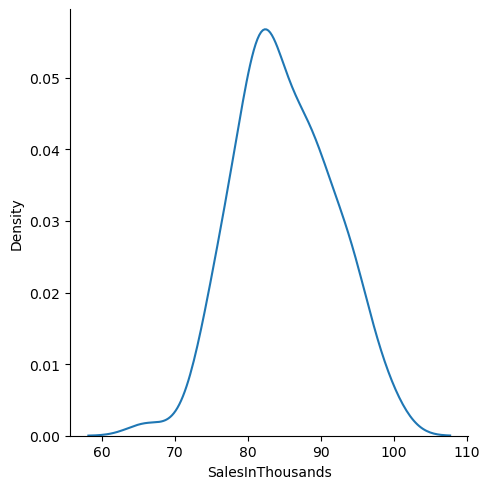

In [25]:
sns.displot(data=high_mode_locations_df, x="SalesInThousands", kind="kde")
plt.show()

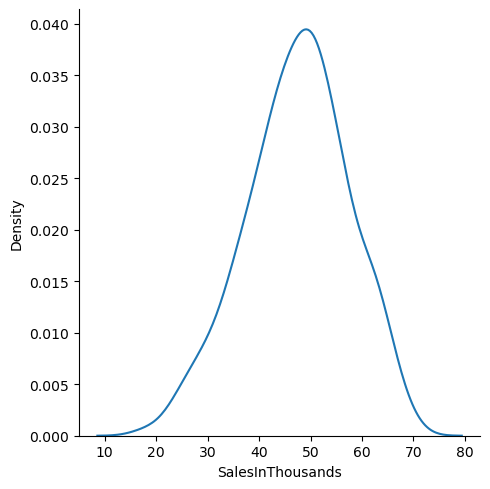

In [26]:
sns.displot(data=low_mode_locations_df, x="SalesInThousands", kind="kde")
plt.show()

#### Since there does not appear to be any bimodal nature to these distributions, we can solely work with these distributions rather than having to divide them further based on values of other variables. However, we need to know whether they are approximately normally distributed.

#### While we see that these distributions look fairly normal, we will test them empirically using the Anderson-Darling test for normality:

#### For Anderson-Darling, Null hypothesis (H₀): The data come from a normal distribution. The test statistic measures how far the empirical distribution deviates from a normal one. 



In [27]:
from scipy.stats import anderson
result = anderson(high_mode_locations_df["SalesInThousands"])

print(round(result.statistic, 4))
print(result.significance_level)
print(result.critical_values)


from scipy.stats import anderson
result = anderson(high_mode_locations_df["SalesInThousands"], method='interpolate')

print(round(result.statistic, 4))
print(result.pvalue)

0.3777
[15.  10.   5.   2.5  1. ]
[0.556 0.625 0.745 0.865 1.026]
0.3777
0.15


/tmp/ipykernel_895/2628820791.py:2: FutureWarning: As of SciPy 1.17, users must choose a p-value calculation method by providing the `method` parameter. `method='interpolate'` interpolates the p-value from pre-calculated tables; `method` may also be an instance of `MonteCarloMethod` to approximate the p-value via Monte Carlo simulation. When `method` is specified, the result object will include a `pvalue` attribute and not attributes `critical_value`, `significance_level`, or `fit_result`. Beginning in 1.19.0, these other attributes will no longer be available, and a p-value will always be computed according to one of the available `method` options.
  result = anderson(high_mode_locations_df["SalesInThousands"])


#### Significance levels: [15%, 10%, 5%, 2.5%, 1%]
#### Critical values:     [0.556 0.625 0.745 0.865 1.026]

#### Decision rule:

#### Reject normality if test statistic (0.3777) > critical value at a given significance level.

#### Thus, we cannot reject normality at any level. We cannot reject normality at the 5% (the common cuttoff) or 10% levels. Therefore, the data are consistent with a normal distribution.

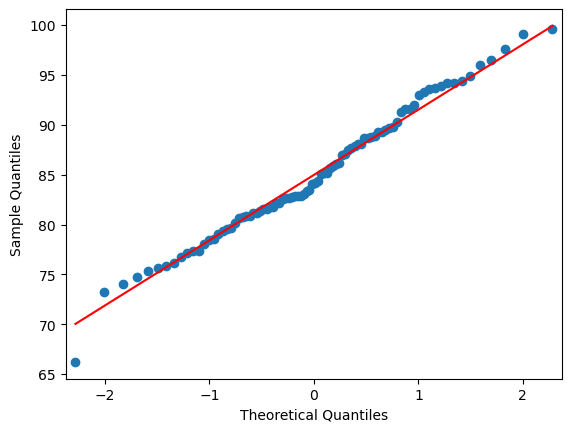

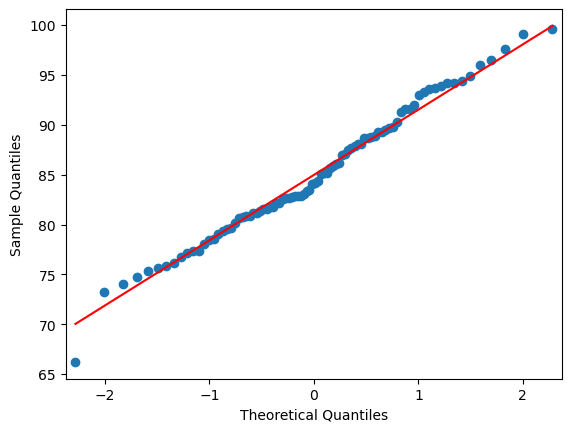

In [28]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats.distributions import norm

qqplot(high_mode_locations_df["SalesInThousands"], line ='s', dist=norm)


---

#### Now, we will do the same with low_mode_locations_df:

In [29]:
result = anderson(low_mode_locations_df["SalesInThousands"])

print(round(result.statistic, 4))
print(result.significance_level)
print(result.critical_values)


from scipy.stats import anderson
result = anderson(low_mode_locations_df["SalesInThousands"], method='interpolate')

print(round(result.statistic, 4))
print(result.pvalue)

0.6004
[15.  10.   5.   2.5  1. ]
[0.56  0.63  0.751 0.872 1.033]
0.6004
0.12117234876960767


/tmp/ipykernel_895/1530018880.py:1: FutureWarning: As of SciPy 1.17, users must choose a p-value calculation method by providing the `method` parameter. `method='interpolate'` interpolates the p-value from pre-calculated tables; `method` may also be an instance of `MonteCarloMethod` to approximate the p-value via Monte Carlo simulation. When `method` is specified, the result object will include a `pvalue` attribute and not attributes `critical_value`, `significance_level`, or `fit_result`. Beginning in 1.19.0, these other attributes will no longer be available, and a p-value will always be computed according to one of the available `method` options.
  result = anderson(low_mode_locations_df["SalesInThousands"])


#### Significance levels: [15%, 10%, 5%, 2.5%, 1%]
#### Critical values:     [0.56, 0.63, 0.751, 0.872, 1.033]

#### Decision rule:

#### Reject normality if test statistic (0.6004) > critical value at a given significance level.

#### Thus, we can only reject normality at the 15% level. We cannot reject normality at the 5% (the common cuttoff) or 10% levels. Therefore, the data are consistent with an approximately normal distribution.

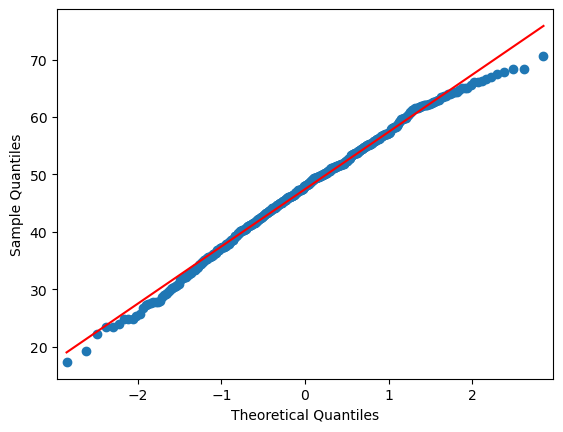

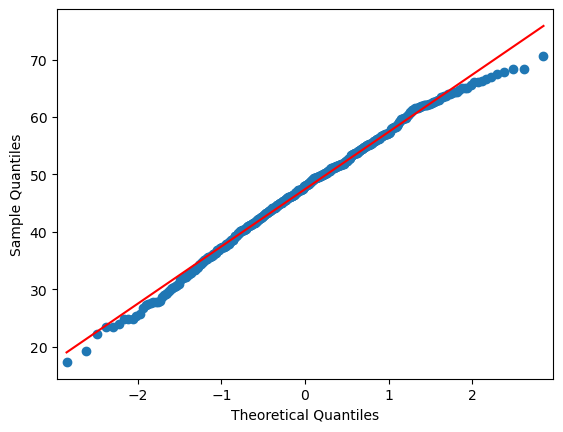

In [30]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats.distributions import norm

qqplot(low_mode_locations_df["SalesInThousands"], line ='s', dist=norm)

#### We can see there is some level of deviation from the normal distribution in the upper quantiles, but overall the fact that the vast majority of the data stays close to or exactly on the diagonal line representing the theoretical normal distribution gives us reason to conclude the distribution is, overall, indeed approximately normal.

---

#### Now we can begin our study:

#### First, I assess the number of unique values for the MarketID and LocationID variables, and the MarketSize distribution in terms of unique LocationID values.

In [31]:
# For my Low-Mode dataset
print("LOW-MODE DATASET:")
print(f"  Unique MarketIDs: {low_mode_locations_df['MarketID'].nunique()}")
print(f"  Unique LocationIDs: {low_mode_locations_df['LocationID'].nunique()}")
print(f"  MarketSize distribution:")
print(low_mode_locations_df.groupby('MarketSize')['LocationID'].nunique())

LOW-MODE DATASET:
  Unique MarketIDs: 9
  Unique LocationIDs: 115
  MarketSize distribution:
MarketSize
Large     20
Medium    80
Small     15
Name: LocationID, dtype: int64


In [32]:
# For your High-Mode dataset
print("HIGH-MODE DATASET:")
print(f"  Unique MarketIDs: {high_mode_locations_df['MarketID'].nunique()}")
print(f"  Unique LocationIDs: {high_mode_locations_df['LocationID'].nunique()}")
print(f"  MarketSize distribution:")
print(high_mode_locations_df.groupby('MarketSize')['LocationID'].nunique())

HIGH-MODE DATASET:
  Unique MarketIDs: 1
  Unique LocationIDs: 22
  MarketSize distribution:
MarketSize
Large    22
Name: LocationID, dtype: int64


#### Based on this assessment, I realize that in high_mode_locations_df, there is only 1 unique MarketID category. The two datasets must fundamentally be treated differently when conducting my observational studies. 

<br>

#### **What This Means**
#### For the high-mode dataset, since all observations come from a single MarketID:

#### - There is no between-market variation to model
#### - Including MarketID in the model would be meaningless (or cause errors)
#### - The model simplifies considerably

<br>

#### The fact that all high-mode locations come from ONE market is very informative. It suggests that being in that specific market is what drives the high sales—not just location-level characteristics.

<br>

#### **Why use a mixed effects model?:**

#### - **Handles hierarchical data structure** — Locations nested within markets, with repeated measures across weeks.
#### - **Properly accounts for non-independence** — Observations from the same location are correlated; ignoring this would inflate false positive rates.
#### - **Adapts to data constraints** — Used nested random effects where possible (low-mode) and simpler structure where necessary (high-mode with only 1 market).

<br>

#### For the low mode dataset, we can conduct a nested mixed effects model:

    MarketSize (3 levels: Small, Medium, Large)
        └── MarketID (multiple markets per size)
                └── LocationID (multiple locations per market)
                        └── Observations (Week × Promotion combinations)

<br>

#### **For each dataset (Low-Mode and High-Mode):**

#### 1. Fit the mixed effects model. 
####    - Since the high-mode dataset has only 1 MarketID value, we cannot have nested effects for its model. But we can for the low-mode dataset. Still, both will be mixed effects models.
#### 2. Extract Promotion coefficients (effect of Promo 2 vs 1, Promo 3 vs 1)
#### 3. Report effects in dollars with 95% confidence intervals
#### 4. Run post-hoc pairwise comparisons with Tukey adjustment
#### 5. Compare promotion effects across the two datasets                        


---

#### **True nested mixed effects models are defined as follows:**

#### The key syntax is:

    sm.MixedLM.from_formula(
        "y ~ fixed_effects",
        groups="highest_level_grouping",      # e.g., MarketID
        vc_formula={"lower_level": "0 + C(lower_level)"},  # e.g., LocationID
        data=df
    )

#### This creates:
#### - Random intercept for the highest level (groups parameter)
#### - Variance component for the nested lower level (vc_formula)

In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [24]:
# Load and Prepare Data

# If you need to create them from the original df:
# df_low_mode = df[df['LocationID'].isin(low_mode_locations)].copy()
# df_high_mode = df[df['LocationID'].isin(high_mode_locations)].copy()

# Verify the structure
print("LOW MODE DATASET:")
print(f"  Observations: {len(low_mode_locations_df)}")
print(f"  Unique MarketIDs: {low_mode_locations_df['MarketID'].nunique()}")
print(f"  Unique LocationIDs: {low_mode_locations_df['LocationID'].nunique()}")
print(f"  MarketIDs: {sorted(low_mode_locations_df['MarketID'].unique())}")

print("\nHIGH MODE DATASET:")
print(f"  Observations: {len(high_mode_locations_df)}")
print(f"  Unique MarketIDs: {high_mode_locations_df['MarketID'].nunique()}")
print(f"  Unique LocationIDs: {high_mode_locations_df['LocationID'].nunique()}")
print(f"  MarketID: {high_mode_locations_df['MarketID'].unique()}")

LOW MODE DATASET:
  Observations: 460
  Unique MarketIDs: 9
  Unique LocationIDs: 115
  MarketIDs: [1, 2, 4, 5, 6, 7, 8, 9, 10]

HIGH MODE DATASET:
  Observations: 88
  Unique MarketIDs: 1
  Unique LocationIDs: 22
  MarketID: [3]
Categories (10, int64): [1, 2, 3, 4, ..., 7, 8, 9, 10]


### Low Mode:

In [39]:
# Prepare Low Mode Data for Analysis

# Create a copy for modeling
df_low = low_mode_locations_df.copy()

# Convert categorical variables to category dtype
df_low['Promotion'] = df_low['Promotion'].astype('category')
df_low['week'] = df_low['week'].astype('category')
df_low['MarketID'] = df_low['MarketID'].astype('category')
df_low['LocationID'] = df_low['LocationID'].astype('category')

# Keep AgeOfStore as numeric (continuous)
df_low['AgeOfStore'] = df_low['AgeOfStore'].astype(float)

# Verify
print("Variable types for Low Mode:")
print(df_low.dtypes)

Variable types for Low Mode:
MarketID            category
MarketSize            object
LocationID          category
AgeOfStore           float64
Promotion           category
week                category
SalesInThousands     float64
dtype: object


In [43]:
# Fit Low Mode Model - NESTED MIXED EFFECTS
# 
# This is a LINEAR MIXED EFFECTS MODEL with:
# - FIXED EFFECTS: Promotion, week, AgeOfStore (effects we estimate directly)
# - RANDOM EFFECTS: MarketID (level 2), LocationID nested within MarketID (level 1)
#
# The model accounts for:
# - Different baseline sales for each market (random intercept)
# - Different baseline sales for each location within markets (nested random intercept)

model_low = sm.MixedLM.from_formula(
    formula="SalesInThousands ~ C(Promotion) + C(week) + AgeOfStore",
    groups="MarketID",                                    # Level 2 random effect
    vc_formula={"LocationID": "0 + C(LocationID)"},       # Level 1 random effect (nested)
    data=df_low
)

# Fit the model
result_low = model_low.fit(method='lbfgs')

# Display results
print("=" * 62)
print("LOW MODE: NESTED MIXED EFFECTS MODEL")
print("=" * 62)
print("\nModel: SalesInThousands ~ Promotion + week + AgeOfStore + (1|MarketID/LocationID)")
print("\nThis is a MIXED EFFECTS model because it has:")
print("  - Fixed effects: Promotion, week, AgeOfStore")
print("  - Random effects: MarketID (level 2), LocationID (level 1, nested)")
print("\n")
print(result_low.summary())

LOW MODE: NESTED MIXED EFFECTS MODEL

Model: SalesInThousands ~ Promotion + week + AgeOfStore + (1|MarketID/LocationID)

This is a MIXED EFFECTS model because it has:
  - Fixed effects: Promotion, week, AgeOfStore
  - Random effects: MarketID (level 2), LocationID (level 1, nested)


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: SalesInThousands
No. Observations: 460     Method:             REML            
No. Groups:       9       Scale:              26.1965         
Min. group size:  24      Log-Likelihood:     -1530.1392      
Max. group size:  80      Converged:          Yes             
Mean group size:  51.1                                        
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept          50.983    1.736 29.362 0.000  47.580 54.386
C(Promotion)[T.2]  -9.259    1.867 

#### **Interpretation:**

#### Baseline Performance
#### Intercept: 50.98 (p < 0.001)

#### - Expected sales are approximately `$51,000` for a new store (age=0) in week 1 with promotion type 1

<br>

#### Promotion Effects
#### Promotion 2: -9.26 (p < 0.001)

#### - Stores running Promotion 2 sell `$9,260` less than Promotion 1 (baseline)
#### - This is a substantial and statistically significant negative impact

<br>

#### Promotion 3: -3.73 (p = 0.050)

#### - Stores running Promotion 3 sell `$3,730` less than Promotion 1
#### - Marginally significant (right at the 0.05 threshold)

<br>

#### **→ Promotion 1 clearly outperforms the other two promotions. The second best appears to be promotion 3, and the worst performing appears to be promotion 2. We will use a post-hoc analysis to be sure of the order of promotions between 3 and 2 in relation to promotion 1.**

<br>

#### Week Effects
#### Weeks 2-4: Coefficients near 0 (all p > 0.05)

#### -No significant difference in sales across the 4-week period
#### -Sales are relatively stable week-to-week

<br>

#### Store Age Effect
#### AgeOfStore: 0.11 (p = 0.323)

#### - Not statistically significant
#### - Older stores don't necessarily perform better/worse than newer ones

<br>

#### Variance Components
#### LocationID Variance: 60.10

#### - Substantial variability exists between individual store locations
#### - Even after accounting for market differences, individual location characteristics matter significantly

<br>

#### **Business Implications**

#### 1. Switch to Promotion 1 - It significantly outperforms Promotions 2 and 3
#### 2. Location matters - The high location variance suggests site selection and local factors are critical
#### 3. Timing is flexible - No evidence that certain weeks perform better (within this 4-week window)
#### 4. Store age doesn't matter - New and established stores can perform equally well

In [27]:
# Extract Promotion Effects - Low Mode

print("=" * 70)
print("PROMOTION EFFECTS - LOW MODE")
print("=" * 70)
print("\n(Reference category: Promotion 1)")
print("\n")

# Extract promotion effects
promo_results_low = []

for param in result_low.params.index:
    if 'Promotion' in param:
        coef = result_low.params[param]
        se = result_low.bse[param]
        pval = result_low.pvalues[param]
        ci_low, ci_high = result_low.conf_int().loc[param]
        
        # Determine significance
        if pval < 0.001:
            sig = '***'
        elif pval < 0.01:
            sig = '**'
        elif pval < 0.05:
            sig = '*'
        else:
            sig = ''
        
        promo_results_low.append({
            'Comparison': param.replace('C(Promotion)[T.', 'Promotion ').replace(']', ' vs 1'),
            'Effect (thousands)': coef,
            'Effect ($)': coef * 1000,
            'Std Error': se,
            '95% CI Lower': ci_low,
            '95% CI Upper': ci_high,
            'p-value': pval,
            'Sig': sig
        })

promo_df_low = pd.DataFrame(promo_results_low)
print(promo_df_low.to_string(index=False))

print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")

PROMOTION EFFECTS - LOW MODE

(Reference category: Promotion 1)


      Comparison  Effect (thousands)   Effect ($)  Std Error  95% CI Lower  95% CI Upper      p-value Sig
Promotion 2 vs 1           -9.258664 -9258.663964   1.867335    -12.918573     -5.598755 7.114048e-07 ***
Promotion 3 vs 1           -3.734159 -3734.159367   1.903609     -7.465164     -0.003155 4.980658e-02   *

Significance: *** p<0.001, ** p<0.01, * p<0.05


### High mode:

In [44]:
# Prepare High Mode Data for Analysis

# Create a copy for modeling
df_high = high_mode_locations_df.copy()

# Convert categorical variables to category dtype
df_high['Promotion'] = df_high['Promotion'].astype('category')
df_high['week'] = df_high['week'].astype('category')
df_high['LocationID'] = df_high['LocationID'].astype('category')

# Keep AgeOfStore as numeric (continuous)
df_high['AgeOfStore'] = df_high['AgeOfStore'].astype(float)

# Verify
print("Variable types for High Mode:")
print(df_high.dtypes)

print(f"\nNote: Only 1 MarketID ({df_high['MarketID'].unique()[0]}) - cannot use nested random effects")

Variable types for High Mode:
MarketID            category
MarketSize            object
LocationID          category
AgeOfStore           float64
Promotion           category
week                category
SalesInThousands     float64
dtype: object

Note: Only 1 MarketID (3) - cannot use nested random effects


In [47]:
# Fit High Mode Model - SIMPLE MIXED EFFECTS
#
# This is a LINEAR MIXED EFFECTS MODEL with:
# - FIXED EFFECTS: Promotion, week, AgeOfStore
# - RANDOM EFFECTS: LocationID only (cannot nest - only 1 market exists)
#
# Note: This model is SIMPLER than the low mode model because
# we cannot estimate between-market variance with only 1 market.

model_high = sm.MixedLM.from_formula(
    formula="SalesInThousands ~ C(Promotion) + C(week) + AgeOfStore",
    groups="LocationID",  # Only random effect possible
    data=df_high
)

# Fit the model
result_high = model_high.fit(method='lbfgs')

# Display results
print("=" * 62)
print("HIGH MODE: SIMPLE MIXED EFFECTS MODEL")
print("=" * 62)
print("\nModel: SalesInThousands ~ Promotion + week + AgeOfStore + (1|LocationID)")
print("\nThis is a MIXED EFFECTS model because it has:")
print("  - Fixed effects: Promotion, week, AgeOfStore")
print("  - Random effects: LocationID only")
print("\n⚠️  Cannot include MarketID - only 1 market in this dataset")
print("\n")
print(result_high.summary())

HIGH MODE: SIMPLE MIXED EFFECTS MODEL

Model: SalesInThousands ~ Promotion + week + AgeOfStore + (1|LocationID)

This is a MIXED EFFECTS model because it has:
  - Fixed effects: Promotion, week, AgeOfStore
  - Random effects: LocationID only

⚠️  Cannot include MarketID - only 1 market in this dataset


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: SalesInThousands
No. Observations: 88      Method:             REML            
No. Groups:       22      Scale:              27.7084         
Min. group size:  4       Log-Likelihood:     -262.8746       
Max. group size:  4       Converged:          Yes             
Mean group size:  4.0                                         
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept          92.197    1.523 60.522 0.000  89.211 95.183
C(Promotion)[T.

/home/rsb84/miniconda3/envs/torch_geo_env/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


#### **Interpretation:**

#### Baseline Performance
#### Intercept: 92.20 (p < 0.001)

#### - Expected sales are approximately `$92,200` for a new store (age=0) in week 1 with promotion type 1
#### - Note: This is substantially higher (~`$41k` more) than the LOW MODE intercept, suggesting this high-performing market differs meaningfully from the multi-market dataset

<br>

#### Promotion Effects (Strongest Finding)

#### Promotion 2: -9.80 (p < 0.001)

#### - Stores running Promotion 2 sell `$9,800` less than Promotion 1
#### - Very similar to LOW MODE (`-$9,260`), suggesting this promotion effect is consistent across markets

<br>

#### Promotion 3: -4.69 (p = 0.001)

#### - Stores running Promotion 3 sell `$4,690` less than Promotion 1
#### - More strongly significant than in LOW MODE (p=0.001 vs p=0.050)
#### - Slightly larger negative effect than LOW MODE (`-$3,730`)

<br>

#### **→ Promotion 1 is clearly superior in this market, consistent with LOW MODE findings. Similarly, promotion 3 appears to be the second best performing promotion, and promotion 2 appears to be the worst performing. However, we must analyze the differences between promotions 1, 2, and 3, to be sure, using a post-hoc analysis.**

<br>

#### Week Effects (New Finding)
#### Week 2: -3.88 (p = 0.014). Week 3: -1.63 (p = 0.303). Week 4: -2.49 (p = 0.116)

#### - Sales in week 2 are `$3,880` lower than week 1
#### - Week 2 is statistically significant - unlike LOW MODE where weeks didn't matter. However, weeks 3 and 4 are not statistically significant

<br>

#### Store Age Effect
#### AgeOfStore: -0.087 (p = 0.350)

#### - Not statistically significant
#### - Slight negative trend (older stores sell less) but not reliable
#### - Consistent with LOW MODE (no age effect)

<br>

#### Variance Components (Critical Difference)
#### LocationID Variance: 0.29

#### - Very low compared to LOW MODE (60.10)
#### - Locations within this single market are remarkably homogeneous
#### - Individual location characteristics matter very little here

<br>

#### **Business Implications**

#### - This market is high-performing - Base sales are ~80% higher than the multi-market average
#### - Promotion 1 is still the winner - Effect is consistent and even stronger here
#### - Week 1 is critical - Unlike the multi-market data of LOW MODE, there is a significant week 2 drop in this market
#### - Locations are interchangeable - Very low location variance suggests standardization/consistency within this market
#### - Market-level factors dominate - The huge difference in intercepts shows market selection matters more than individual locations



In [48]:
# Extract Promotion Effects - High Mode

print("=" * 70)
print("PROMOTION EFFECTS - HIGH MODE")
print("=" * 70)
print("\n(Reference category: Promotion 1)")
print("\n")

# Extract promotion effects
promo_results_high = []

for param in result_high.params.index:
    if 'Promotion' in param:
        coef = result_high.params[param]
        se = result_high.bse[param]
        pval = result_high.pvalues[param]
        ci_low, ci_high = result_high.conf_int().loc[param]
        
        # Determine significance
        if pval < 0.001:
            sig = '***'
        elif pval < 0.01:
            sig = '**'
        elif pval < 0.05:
            sig = '*'
        else:
            sig = ''
        
        promo_results_high.append({
            'Comparison': param.replace('C(Promotion)[T.', 'Promotion ').replace(']', ' vs 1'),
            'Effect (thousands)': coef,
            'Effect ($)': coef * 1000,
            'Std Error': se,
            '95% CI Lower': ci_low,
            '95% CI Upper': ci_high,
            'p-value': pval,
            'Sig': sig
        })

promo_df_high = pd.DataFrame(promo_results_high)
print(promo_df_high.to_string(index=False))

print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")

PROMOTION EFFECTS - HIGH MODE

(Reference category: Promotion 1)


      Comparison  Effect (thousands)   Effect ($)  Std Error  95% CI Lower  95% CI Upper      p-value Sig
Promotion 2 vs 1           -9.803679 -9803.678933   1.518609    -12.780098     -6.827260 1.077230e-10 ***
Promotion 3 vs 1           -4.692236 -4692.235782   1.354265     -7.346546     -2.037925 5.306568e-04 ***

Significance: *** p<0.001, ** p<0.01, * p<0.05


In [49]:
# Compare Promotion Effects Across Datasets

print("=" * 70)
print("COMPARISON: PROMOTION EFFECTS ACROSS DATASETS")
print("=" * 70)

print("\n⚠️  IMPORTANT CAVEATS:")
print("   1. Models are not identical (Low Mode has nested random effects, High Mode does not)")
print("   2. High Mode results apply only to a single market")
print("   3. Sample sizes differ between datasets")
print("\n")

# Create comparison table
comparison_data = []

for param in result_low.params.index:
    if 'Promotion' in param:
        low_coef = result_low.params[param]
        low_pval = result_low.pvalues[param]
        
        if param in result_high.params.index:
            high_coef = result_high.params[param]
            high_pval = result_high.pvalues[param]
            
            comparison_data.append({
                'Effect': param.replace('C(Promotion)[T.', 'Promo ').replace(']', ' vs 1'),
                'Low Mode ($)': f"${low_coef*1000:,.0f}",
                'Low p-value': f"{low_pval:.4f}",
                'High Mode ($)': f"${high_coef*1000:,.0f}",
                'High p-value': f"{high_pval:.4f}",
                'Difference ($)': f"${(high_coef - low_coef)*1000:,.0f}"
            })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

COMPARISON: PROMOTION EFFECTS ACROSS DATASETS

⚠️  IMPORTANT CAVEATS:
   1. Models are not identical (Low Mode has nested random effects, High Mode does not)
   2. High Mode results apply only to a single market
   3. Sample sizes differ between datasets


      Effect Low Mode ($) Low p-value High Mode ($) High p-value Difference ($)
Promo 2 vs 1      $-9,259      0.0000       $-9,804       0.0000          $-545
Promo 3 vs 1      $-3,734      0.0498       $-4,692       0.0005          $-958


In [50]:
# Summary and Conclusions

print("=" * 70)
print("SUMMARY")
print("=" * 70)

print("""
MODEL TYPE: Linear Mixed Effects Models (LMM)
─────────────────────────────────────────────
Both models are MIXED EFFECTS models because they contain:
- Fixed effects (Promotion, week, AgeOfStore) - estimated directly
- Random effects (LocationID, and MarketID in low mode) - variance estimated

LOW MODE MODEL:
- Formula: Sales ~ Promotion + week + AgeOfStore + (1|MarketID/LocationID)
- Nested random effects: LocationID within MarketID
- Allows estimation of variance at both market and location levels

HIGH MODE MODEL:
- Formula: Sales ~ Promotion + week + AgeOfStore + (1|LocationID)
- Simple random intercept: LocationID only
- Cannot estimate market-level variance (only 1 market)

KEY FINDINGS:
""")

# Print key findings
print(f"Low Mode Dataset:")
print(f"  - Promotion 2 vs 1: ${result_low.params['C(Promotion)[T.2]']*1000:,.0f} (p={result_low.pvalues['C(Promotion)[T.2]']:.4f})")
print(f"  - Promotion 3 vs 1: ${result_low.params['C(Promotion)[T.3]']*1000:,.0f} (p={result_low.pvalues['C(Promotion)[T.3]']:.4f})")

print(f"\nHigh Mode Dataset:")
print(f"  - Promotion 2 vs 1: ${result_high.params['C(Promotion)[T.2]']*1000:,.0f} (p={result_high.pvalues['C(Promotion)[T.2]']:.4f})")
print(f"  - Promotion 3 vs 1: ${result_high.params['C(Promotion)[T.3]']*1000:,.0f} (p={result_high.pvalues['C(Promotion)[T.3]']:.4f})")

SUMMARY

MODEL TYPE: Linear Mixed Effects Models (LMM)
─────────────────────────────────────────────
Both models are MIXED EFFECTS models because they contain:
- Fixed effects (Promotion, week, AgeOfStore) - estimated directly
- Random effects (LocationID, and MarketID in low mode) - variance estimated

LOW MODE MODEL:
- Formula: Sales ~ Promotion + week + AgeOfStore + (1|MarketID/LocationID)
- Nested random effects: LocationID within MarketID
- Allows estimation of variance at both market and location levels

HIGH MODE MODEL:
- Formula: Sales ~ Promotion + week + AgeOfStore + (1|LocationID)
- Simple random intercept: LocationID only
- Cannot estimate market-level variance (only 1 market)

KEY FINDINGS:

Low Mode Dataset:
  - Promotion 2 vs 1: $-9,259 (p=0.0000)
  - Promotion 3 vs 1: $-3,734 (p=0.0498)

High Mode Dataset:
  - Promotion 2 vs 1: $-9,804 (p=0.0000)
  - Promotion 3 vs 1: $-4,692 (p=0.0005)


---

#### **Post-hoc analysis - Alternative to Tukey's HSD:**



#### **The Problem: Multiple Comparisons**

#### Both mixed effects models show significant promotion effects, but they only tell you:

#### - "Promotions 2 and 3 differ from (and promote less sales than) the baseline (Promotion 1)"
#### - Specifically, mixed effects models alone provides 2 of the 3 necessary pairwise comparisons; we know that Promotion 1 appears better than Promotion 2, and that Promotion 1 appears better than Promotion 3. I.e., mixed effects models compare Promotions 2 and 3 to the baseline.

<br>

#### However, what the mixed effects models DON'T tell you:

#### - Is Promotion 2 significantly different from Promotion 3, and how? Because Promotion 1 is the baseline.
#### - What are ALL pairwise differences?

---

#### **Why Not Use Standard Tukey's HSD?**

#### Honestly Significant Difference (HSD) conducts all pairwise comparisons while controlling for:

#### - Family-wise error rate - When you make multiple comparisons, your chance of finding a "false positive" increases. With 3 promotions, you have 3 pairwise comparisons:

####     - Promotion 1 vs 2
####     - Promotion 1 vs 3
####     - Promotion 2 vs 3

#### Without correction, if each test has α=0.05, your overall Type I error rate could be much higher.

#### Adjusted p-values - Tukey's HSD gives you conservative p-values that account for testing multiple hypotheses simultaneously

#### However, Standard Tukey's HSD (pairwise_tukeyhsd) assumes independent observations. My data violates this assumption because:

####  - The same locations appear multiple times (repeated measures across weeks)
####  - Locations are nested within markets

#### Using Tukey's HSD on hierarchical data produces anti-conservative p-values (too small) because it treats 460 observations as independent when they're actually clustered. This inflates Type I error rates.

---

#### **Why Extract Comparisons from the Mixed Effects Model Instead?**

#### The mixed effects model already accounts for the hierarchical structure through random effects. By extracting pairwise comparisons directly from the model's coefficients and covariance matrix, we:

####  - Maintain the correct standard errors that account for clustering
####  - Get valid p-values for hierarchical data
####  - Properly handle the non-independence of observations


#### **The Calculation for Promo 2 vs Promo 3**
#### Difference = β₂ - β₃ = -9.259 - (-3.734) = -5.525

#### SE = √(Var(β₂) + Var(β₃) - 2·Cov(β₂,β₃))

#### z = Difference / SE

#### p-value = 2 × (1 - Φ(|z|))  # Two-tailed test



#### **Why It Matters for Business Decisions**

#### *Scenario 1: If extracting comparisons shows Promo 2 ≠ Promo 3 (p < 0.05)*

####     - Decision: Use Promotion 1 (best), then Promotion 3 (second-best), never use Promotion 2 (worst)

#### *Scenario 2: If extracting comparisons shows Promo 2 = Promo 3 (p > 0.05)*

####     - Decision: Use Promotion 1; Promotions 2 and 3 are equally ineffective
####     - If cost/implementation differs, choose the cheaper of Promo 2 or 3 as backup

---

### Low Mode Dataset

In [51]:
# All pairwise comparisons from mixed effects (correct SEs)
import numpy as np
from scipy import stats

def get_all_pairwise_comparisons(result):
    """Extract all pairwise comparisons from mixed effects model."""
    
    comparisons = []
    
    # Promo 2 vs Promo 1 (directly from model)
    comparisons.append({
        'comparison': 'Promo 2 vs Promo 1',
        'difference': result.params['C(Promotion)[T.2]'],
        'p_value': result.pvalues['C(Promotion)[T.2]']
    })
    
    # Promo 3 vs Promo 1 (directly from model)
    comparisons.append({
        'comparison': 'Promo 3 vs Promo 1',
        'difference': result.params['C(Promotion)[T.3]'],
        'p_value': result.pvalues['C(Promotion)[T.3]']
    })
    
    # Promo 2 vs Promo 3 (calculate from covariance)
    coef_2 = result.params['C(Promotion)[T.2]']
    coef_3 = result.params['C(Promotion)[T.3]']
    diff = coef_2 - coef_3
    
    cov = result.cov_params()
    se = np.sqrt(
        cov.loc['C(Promotion)[T.2]', 'C(Promotion)[T.2]'] +
        cov.loc['C(Promotion)[T.3]', 'C(Promotion)[T.3]'] -
        2 * cov.loc['C(Promotion)[T.2]', 'C(Promotion)[T.3]']
    )
    
    z = diff / se
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    
    comparisons.append({
        'comparison': 'Promo 2 vs Promo 3',
        'difference': diff,
        'p_value': p
    })
    
    # Apply Bonferroni correction
    for c in comparisons:
        c['p_bonferroni'] = min(c['p_value'] * 3, 1.0)
    
    return pd.DataFrame(comparisons)

# Use it
pairwise_df = get_all_pairwise_comparisons(result_low)
print(pairwise_df)

           comparison  difference       p_value  p_bonferroni
0  Promo 2 vs Promo 1   -9.258664  7.114048e-07      0.000002
1  Promo 3 vs Promo 1   -3.734159  4.980658e-02      0.149420
2  Promo 2 vs Promo 3   -5.524505  2.873225e-03      0.008620


### High Mode Dataset

In [52]:
# Use it
pairwise_df = get_all_pairwise_comparisons(result_high)
print(pairwise_df)

           comparison  difference       p_value  p_bonferroni
0  Promo 2 vs Promo 1   -9.803679  1.077230e-10  3.231689e-10
1  Promo 3 vs Promo 1   -4.692236  5.306568e-04  1.591970e-03
2  Promo 2 vs Promo 3   -5.111443  3.680056e-04  1.104017e-03


### **Findings**

<img src="image-1.png" width="55%"/>

---

<img src="image-2.png" width="55%"/>

#### **Please note:** This is an observational analysis. The non-randomized design precludes causal interpretation. Results suggest associations that warrant further investigation through randomized experiments.

